In [4]:
import torch
from torch.fft import fft, ifft
import torchaudio
import numpy as np
import matplotlib.pyplot as plt

### overlap-add
[DFT LPF IDFT of a speech signal using overlap add and overlap save method]
- Read the input .wav file.
- The LPF is simply moving average filter, i.e., ℎ[𝑛]=1,0≤𝑛≤10 (𝑃=11)

1) For overlap add method,
- Frame shift is 80 samples. (𝐿=80)
- For every 80 samples, take 128 point FFT. (𝑁=128)
- Multiply it with the FFT of the filter.
- Compute 128 point IFFT and reconstruct the time domain signal.
- Plot of the magnitude spectrum for the 100th frame with that of the input signal before filtering for each method.
- Compare the outputs of the overlap add and overlap save methods.

In [37]:
def overlap_add2(signal, LPF, frame_shift, fft_point, overlap_length):
    output_length1 = waveform.size(0) + overlap
    output_signal1 = torch.zeros(output_length1)
    h_fft = torch.fft.fft(h, N)

    for i in range(0, waveform.size(0), L):
        frame = waveform[i:i+L]

        frame_fft = torch.fft.fft(frame, N)
        filtered_frame_fft = frame_fft * h_fft
        
        if i == 99*80:
            before_filtering1 = frame_fft
            after_filtering1 = filtered_frame_fft
        filtered_frame = torch.fft.ifft(filtered_frame_fft)

        frame_length = min(N, output_signal1.size(0) - i)
        output_signal1[i:i + frame_length] += filtered_frame[:frame_length].real
    
    return output_signal1[:waveform.size(0)], before_filtering1, after_filtering1


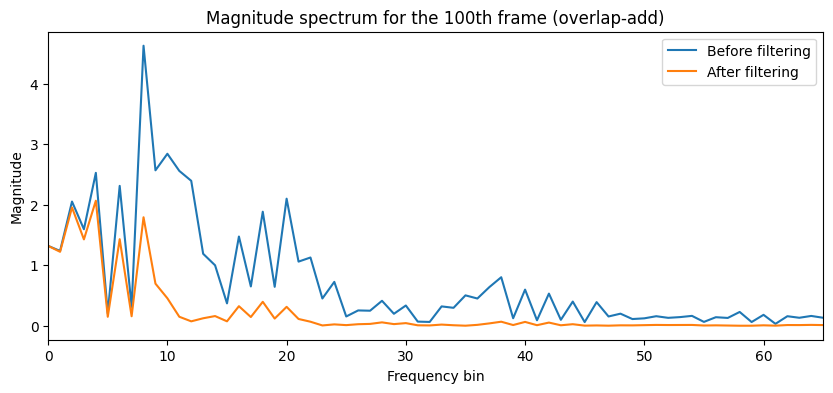

In [38]:
waveform, sr = torchaudio.load('input.wav')
waveform = waveform[0]

P = 11
h = torch.ones(P) / P
L = 80  
N = 128
overlap = N - L 

output2_1 = overlap_add2(waveform, h, L, N, overlap)[0]
torchaudio.save("output2_1.wav", output2_1.unsqueeze(0), sr)

Y1 = abs(before_filtering1)
Y2 = abs(after_filtering1)
plt.figure(figsize=(10,4))
plt.plot(Y1, label = 'Before filtering')
plt.plot(Y2, label = 'After filtering')
plt.xlim(0,65)
plt.title("Magnitude spectrum for the 100th frame (overlap-add)")
plt.xlabel("Frequency bin")
plt.ylabel("Magnitude")
plt.legend()
plt.show()

# Y0 = abs(torch.fft.fft(waveform[99*80:100*80]))
# plt.plot(Y0, label = 'Original')

### overlap-save
[DFT LPF IDFT of a speech signal using overlap add and
overlap save method]
- Read the input .wav file.
- The LPF is simply moving average filter, i.e., ℎ[𝑛]=1,0≤𝑛≤10 (𝑃=11)

2) For overlap save method,
- Frame shift is 80 samples. (𝐿−𝑃+1=80→𝐿=90)
- For every 80 samples, take 128 point FFT for 90 samples of input. (𝑁=128)
- Multiply it with the FFT of the filter.
- Compute 128 point IFFT and reconstruct the time domain signal.

- Plot of the magnitude spectrum for the 100th frame with that of the input signal before filtering for each method.
- Compare the outputs of the overlap add and overlap save methods.

In [50]:
def overlap_save(signal, LPF, frame_size, fft_point, frame_shift):
    h_fft = torch.fft.fft(h, n=N)
    num_frames = (waveform.size(0) - L + frame_shift) // frame_shift
    output_signal2 = torch.zeros(waveform.size(0))

    for i in range(num_frames):
        start_idx = i * frame_shift
        end_idx = start_idx + L
        
        if end_idx > waveform.size(0):
            break
        
        frame = waveform[start_idx:end_idx]
        frame_padded = torch.cat([frame, torch.zeros(N - L)])
        
        frame_fft = torch.fft.fft(frame_padded, n=N)
        filtered_frame_fft = frame_fft * h_fft
        filtered_padded = torch.fft.ifft(filtered_frame_fft, n=N).real
        
        output_signal2[start_idx:start_idx + frame_shift] += filtered_padded[P-1:L]

        if i == 99:
            before_filtering2 = frame_fft
            after_filtering2 = filtered_frame_fft

    return output_signal2[:waveform.size(0)], before_filtering2, after_filtering2


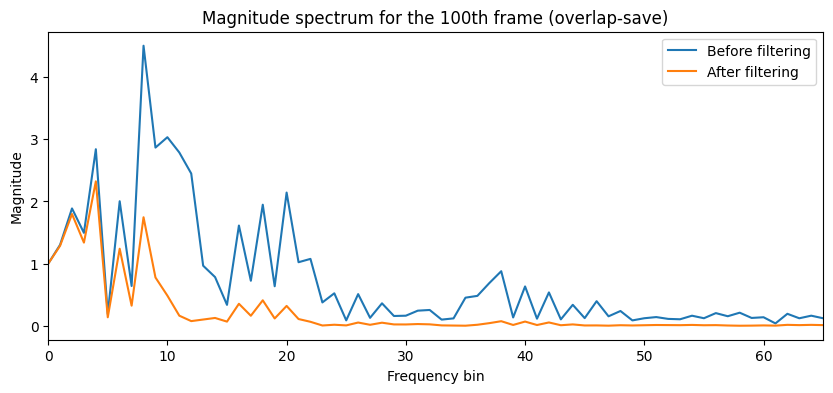

In [51]:
waveform, sr = torchaudio.load('input.wav')
waveform = waveform[0] 

P = 11
h = torch.ones(P) / P
L = 90
N = 128
shift = 80

output2_2 = overlap_save(waveform, h, L, N, shift)[0]
torchaudio.save('output2_2.wav', output_signal2.unsqueeze(0), sr)

Y3 = abs(before_filtering2)
Y4 = abs(after_filtering2)
plt.figure(figsize=(10,4))
plt.plot(Y3, label = 'Before filtering')
plt.plot(Y4, label = 'After filtering')
plt.xlim(0,65)
plt.title("Magnitude spectrum for the 100th frame (overlap-save)")
plt.xlabel("Frequency bin")
plt.ylabel("Magnitude")
plt.legend()
plt.show()

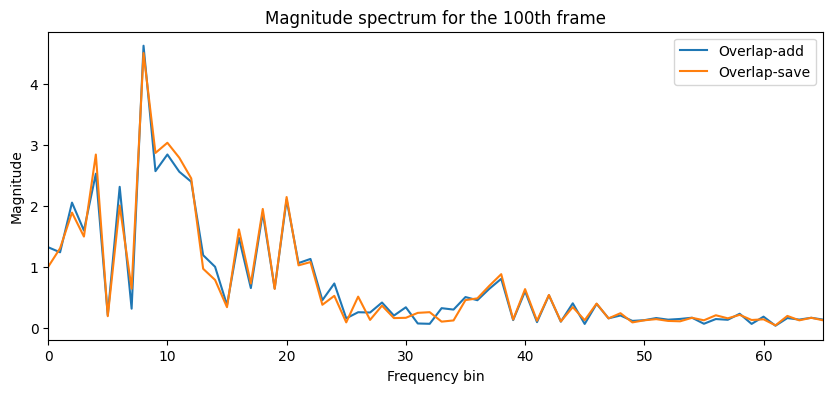

In [52]:
plt.figure(figsize=(10,4))
plt.plot(Y1, label = 'overlap-add')
plt.plot(Y3, label = 'overlap-save')
plt.xlim(0,65)
plt.title("Magnitude spectrum for the 100th frame")
plt.xlabel("Frequency bin")
plt.ylabel("Magnitude")
plt.legend()
plt.show()

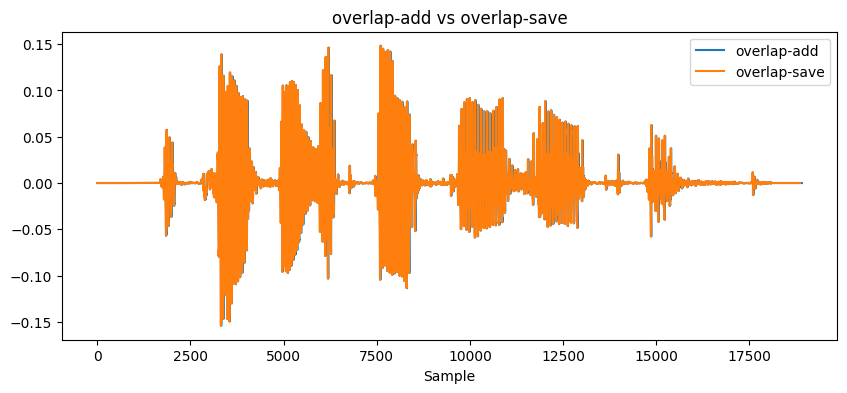

In [55]:
plt.figure(figsize=(10,4))
plt.plot(output_signal1, label="overlap-add")
plt.plot(output_signal2, label="overlap-save")
plt.title("overlap-add vs overlap-save")
plt.xlabel("Sample")
plt.legend()
plt.show()

### overlap-add method with windowing

In [107]:
import scipy.signal

filename = 'input.wav'
waveform, sr = torchaudio.load(filename)
waveform = waveform[0]

# LPF: Moving average filter
P = 11
h = torch.ones(P) / P
L = 80

# Window definition
hann_window = scipy.signal.windows.hann(48)
window = torch.cat([
    torch.tensor(hann_window[:24]),
    torch.ones(56),
    torch.tensor(hann_window[24:]),
    torch.zeros(128 - 104)  # Padding with ones to make the window length 128
])

# Prepare the output signal with padding to accommodate overlap-add
num_frames = (waveform.size(0) + L - 1) // L
output_signal_length = L * num_frames + (N - L)
output_signal3 = torch.zeros(output_signal_length)

# Prepare the padded signal for overlap-add
padded_signal = torch.cat([torch.zeros(24), waveform, torch.zeros(N - (waveform.size(0) % L) - 24)])

for i in range(num_frames):
    # Get the current frame
    start_idx = i * 80
    end_idx = start_idx + N
    frame = padded_signal[start_idx:end_idx]

    if frame.size(0) < N:
        frame = torch.cat([frame, torch.zeros(N - frame.size(0))])

    # Apply the window
    windowed_frame = frame * window

    # Perform FFT
    frame_fft = torch.fft.fft(windowed_frame, n=N)

    if i == 99:
        cc = torch.abs(frame_fft)

    # Perform FFT of the filter
    h_fft = torch.fft.fft(h, n=N)

    # Multiply in frequency domain
    filtered_fft = frame_fft * h_fft

    # Perform IFFT
    filtered_frame = torch.fft.ifft(filtered_fft).real

    # Overlap-add the result to the output signal
    output_signal3[start_idx:start_idx + N] += filtered_frame

# Trim the output signal to the original length
output_signal3 = output_signal3[24:24+waveform.size(0)]


torchaudio.save('output3.wav', output_signal3.unsqueeze(0), sr)


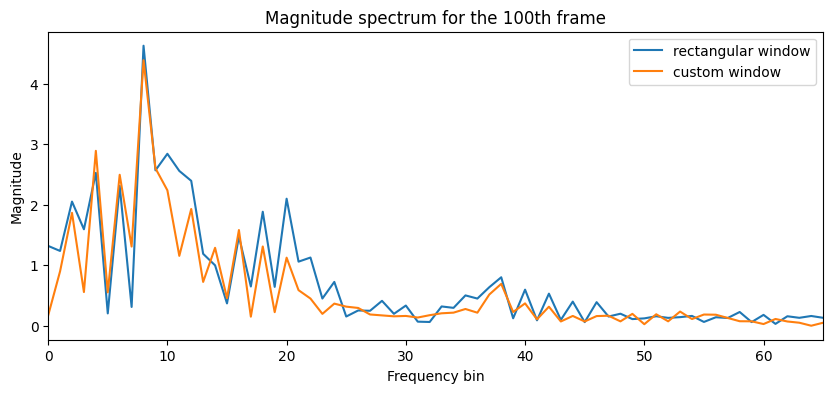

In [105]:
plt.figure(figsize=(10,4))
plt.plot(Y1, label = 'rectangular window')
# plt.plot(Y3, label = 'Overlap-save')
plt.plot(cc, label = 'custom window')
plt.xlim(0,65)
plt.title("Magnitude spectrum for the 100th frame")
plt.xlabel("Frequency bin")
plt.ylabel("Magnitude")
plt.legend()
plt.show()

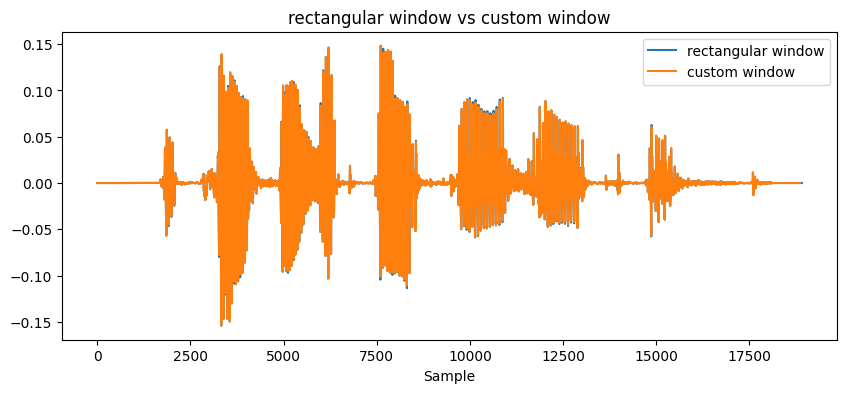

In [106]:
plt.figure(figsize=(10,4))
plt.plot(output_signal1, label="rectangular window")
plt.plot(output_signal3, label="custom window")
plt.title("rectangular window vs custom window")
plt.xlabel("Sample")
plt.legend()
plt.show()